# Trnasfer learning of T5/mT5 model for binary classification


In [1]:
import os
import logging
import re
from pprint import pprint
from glob import glob

import pandas as pd
import numpy as np

import wandb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.special import softmax
from matplotlib import pyplot as plt
import seaborn as sns

from simpletransformers.t5 import T5Model, T5Args

In [2]:
# (optional) Login to WANDB to monitor training progress
try:
    wandb.login()
except Exception as e:
    pprint(e)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matjazmav (use `wandb login --relogin` to force relogin)


True

In [3]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Prepare datasets

In [4]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower()
    return text

def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df["prefix"] = "binary classification"

    data_df.columns = ["input_text", "target_text", "prefix"]
    data_df["input_text"] = data_df["input_text"].map(clean_text)
    data_df = data_df[["prefix", "input_text", "target_text"]]

    return data_df

def load_senti_news_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    data_df["input_text"] = data_df["content"].map(clean_text)
    data_df["target_text"] = data_df["avg_sentiment"].map(lambda x: "NOT" if round(float(x)) >= 3 else "HOF")
    data_df["prefix"] = "binary classification"
    data_df = data_df[["prefix", "input_text", "target_text"]]

    return data_df

train_en_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/english_dataset.tsv")

test_en_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv")
test_de_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv")
test_hi_df = load_hasoc_dataset("data/non-processed/dataset13/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv")
_, test_si_df = train_test_split(load_senti_news_dataset("/hdd/matjazibb/dataset/senti-news/SentiNews_sentence-level.txt"), test_size=0.005)

In [5]:
def random_over_sample(df):
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(df[["prefix", "input_text"]], df["target_text"])
    ros_df = X_resampled
    ros_df["target_text"] = y_resampled
    return ros_df

def random_under_sample(df):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(df[["prefix", "input_text"]], df["target_text"])
    rus_df = X_resampled
    rus_df["target_text"] = y_resampled
    return rus_df

In [6]:
def plot_class_hist(data_df, title):
    data_df["target_text"].value_counts().plot(kind="bar", title=f"Class distirbution: {title}")

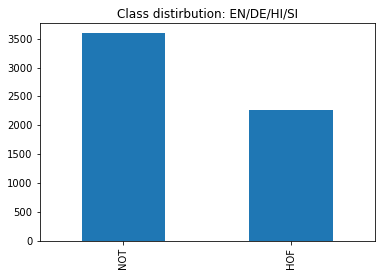

In [7]:
plot_class_hist(train_en_df, "HASOC-EN")

Since classes are unablanced we will use random over sampling to balance out class distribution

In [9]:
train_en_df = random_over_sample(train_en_df)

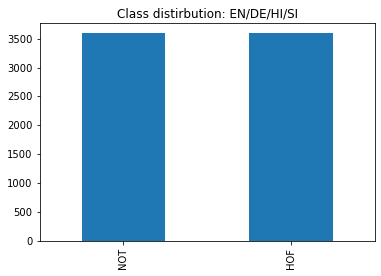

In [10]:
plot_class_hist(train_en_df, "ROS-HASOC-EN")

## Train T5 models

In [11]:
def get_t5_model(model_name, hf_model_type, hf_model_name):
    model_args = T5Args()
    model_args.output_dir=f"/hdd/matjazibb/outputs/{model_name}"
    model_args.best_model_dir=f"{model_args.output_dir}/best_model"
    model_args.cache_dir=f"/hdd/matjazibb/cache_dir/{model_name}"
    model_args.tensorboard_dir=f"/hdd/matjazibb/runs/{model_name}"

    # Training HP
    model_args.fp16 = False # If True model cant be evaluated
    model_args.num_train_epochs = 1
    model_args.learning_rate = 1e-4
    model_args.train_batch_size = 1 # 12GB GPU memory is not enough
    model_args.weight_decay = 1e-4
    model_args.scheduler = "polynomial_decay_schedule_with_warmup"

    # Dataset
    model_args.lazy_loading = True # Because bigger datasets do not fit in the RAM

    # Evaluation
    model_args.evaluate_during_training = False
    model_args.evaluate_each_epoch = False

    # Outputs & cache
    model_args.save_model_every_epoch = True
    model_args.save_steps = -1
    model_args.overwrite_output_dir = True
    model_args.wandb_project = "eval-t5"

    need_training = not os.path.exists(model_args.output_dir)
    pretrained_model_name = hf_model_name if need_training else model_args.output_dir

    return need_training, T5Model(
        hf_model_type, pretrained_model_name,
        args=model_args,
        use_cuda=True,
        cuda_device=0,
    )

In [12]:
need_training, t5_en_model = get_t5_model(
    "t5_en",
    "t5",
    "t5-small",
)

if need_training:
    t5_en_model.train_model(train_en_df)

In [ ]:
# need_training, t5_ml_model = get_t5_model(
#     "t5_ml",
#     "t5",
#     "t5-small",
# )

# if need_training:
#     t5_ml_model.train_model(train_ml_df)

In [13]:
need_training, mt5_en_model = get_t5_model(
    "mt5_en",
    "mt5",
    "google/mt5-small",
)

if need_training:
    mt5_en_model.train_model(train_en_df)

INFO:simpletransformers.t5.t5_utils: Creating features from dataset file at /hdd/matjazibb/cache_dir/mt5_en


  0%|          | 0/7182 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
INFO:simpletransformers.t5.t5_utils: Saving features into cached file /hdd/matjazibb/cache_dir/mt5_en/go

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Running Epoch 0 of 1:   0%|          | 0/7182 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554789074/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))
INFO:simpletransformers.t5.t5_model: Training of google/mt5-small model complete. Saved to /hdd/matjazibb/outputs/mt5_en.


In [ ]:
# need_training, mt5_ml_model = get_t5_model(
#     "mt5_ml",
#     "mt5",
#     "google/mt5-small",
# )

# if need_training:
#     mt5_ml_model.train_model(train_ml_df)

## Evaluate BERT models

In [14]:
def eval_model(model, data_df):
    to_predict = (data_df["prefix"] + ": " + data_df["input_text"]).tolist()
    y_hat = model.predict(to_predict)

    y_true = data_df["target_text"].apply(lambda x: 0 if x == "NOT" else 1)
    y_score = list(map(lambda x: 0 if x == "NOT" else 1, y_hat))

    acc = sklearn.metrics.accuracy_score(y_true, y_score)
    f1 = sklearn.metrics.f1_score(y_true, y_score)
    fpr, tpr, t = sklearn.metrics.roc_curve(y_true, y_score)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, roc_auc, fpr, tpr

In [15]:
eval_models = [
    ("T5-HASOC-en", t5_en_model, test_en_df),
    ("T5-HASOC-de", t5_en_model, test_de_df),
    ("T5-HASOC-hi", t5_en_model, test_hi_df),
    ("T5-SentiNews-si", t5_en_model, test_si_df),

    ("mT5-HASOC-en", mt5_en_model, test_en_df),
    ("mT5-HASOC-de", mt5_en_model, test_de_df),
    ("mT5-HASOC-hi", mt5_en_model, test_hi_df),
    ("mT5-SentiNews-si", mt5_en_model, test_si_df),
]

results = []

for model_name, model, data_df in eval_models:
    f1, roc_auc, fpr, tpr = eval_model(model, data_df)
    results += [(model_name, f1, roc_auc, fpr, tpr)]

Generating outputs:   0%|          | 0/145 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/1153 [00:00<?, ?it/s]

0.4943625325238508


Generating outputs:   0%|          | 0/107 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/850 [00:00<?, ?it/s]

0.31529411764705884


Generating outputs:   0%|          | 0/165 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/1318 [00:00<?, ?it/s]

0.4772382397572079


Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

0.4319526627218935


Generating outputs:   0%|          | 0/145 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c488> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._ho

Decoding outputs:   0%|          | 0/1153 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7e17bf8> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7e17d90> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<l

Generating outputs:   0%|          | 0/107 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c488> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._ho

Decoding outputs:   0%|          | 0/850 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d9c7b8> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1cd90> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<l

Generating outputs:   0%|          | 0/165 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c488> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._ho

Decoding outputs:   0%|          | 0/1318 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c950> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c400> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<l

Generating outputs:   0%|          | 0/106 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:3226: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7d1c488> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._ho

Decoding outputs:   0%|          | 0/845 [00:00<?, ?it/s]

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7db89d8> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x7f09e7db81e0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))
/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/torch/utils/hooks.py:63: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<l

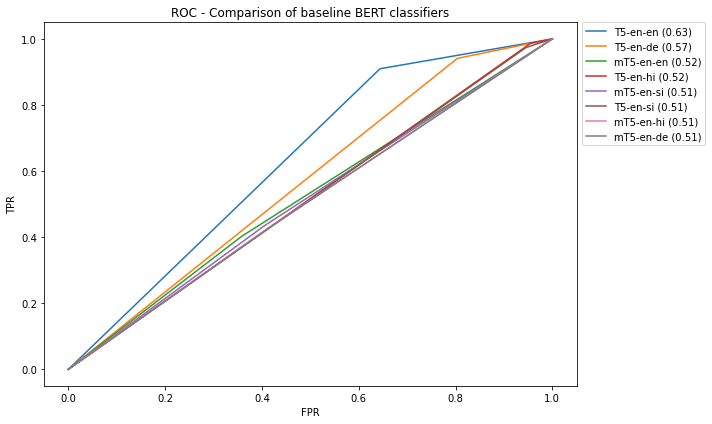

In [16]:
plt.figure(figsize=(10,6))
for model_name, f1, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[2], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline BERT classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.savefig("results/eval-t5-rocs.pdf")

In [18]:
results_df = pd.DataFrame(results, columns=["model_name", "f1", "roc_auc", "fpr", "tpr"])
results_df = results_df.drop(columns=["fpr", "tpr"])
results_df.to_csv("results/eval-t5.csv", index=False)
results_df.head(30)

,model_name,f1,roc_auc
0,T5-en-en,0.473351,0.632896
1,T5-en-de,0.305489,0.568627
2,T5-en-hi,0.634095,0.515829
3,T5-en-si,0.584775,0.514140
4,mT5-en-en,0.324930,0.522198
5,mT5-en-de,0.237219,0.506653
6,mT5-en-hi,0.437004,0.507203
7,mT5-en-si,0.431429,0.514768


In [19]:
%reset